HÜCRE 1: Kütüphaneler, Ayarlar ve Veri Hazırlığı

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
from torchvision import datasets, transforms
import numpy as np
import os
import matplotlib.pyplot as plt

# 1. Cihaz Ayarı
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔥 Cihaz: {device}")

# 2. CIFAR-10 İstatistikleri ve Fonksiyonlar
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std  = (0.2023, 0.1994, 0.2010)

mean_tensor = torch.tensor(cifar10_mean, device=device).view(1, 3, 1, 1)
std_tensor  = torch.tensor(cifar10_std,  device=device).view(1, 3, 1, 1)

def normalize(x):
    return (x - mean_tensor) / std_tensor

def denormalize(x):
    return x * std_tensor + mean_tensor

# 3. Veri Yükleyiciler (DataLoaders)
def get_loaders(batch_size=128):
    train_transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std),
    ])
    test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(cifar10_mean, cifar10_std),
    ])
    
    train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
    test_ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    
    return train_loader, test_loader

# Klasör kontrolü
os.makedirs("checkpoints", exist_ok=True)
train_loader, test_loader = get_loaders()
print("✅ Veri setleri hazırlandı.")

🔥 Cihaz: cuda
✅ Veri setleri hazırlandı.


HÜCRE 2: Model Mimarisi (Full ResNet-18)

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64  # Önceki modelde burası 16 idi, şimdi standart 64'e çektik.

        # CIFAR-10 için özelleştirilmiş giriş katmanı (kernel_size=3, stride=1)
        # ImageNet modellerindeki 7x7 kernel ve maxpool burada kullanılmaz çünkü resimler zaten küçük (32x32).
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2) # 4. Katman eklendi
        
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        # MaxPool yok, CIFAR-10 için gerekli değil.
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNetCIFAR10(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes) # ResNet-18 Yapısı

print("✅ ResNet-18 Modeli tanımlandı (Wide Channels).")

✅ GÜÇLENDİRİLMİŞ ResNet-18 Modeli tanımlandı (Wide Channels).


HÜCRE 3: Saldırı (Attack) ve Değerlendirme Fonksiyonları

FGSM, PGD ve TRADES saldırı mantıkları ile doğruluk ölçüm fonksiyonları burada.

In [ ]:
# --- EVALUATION ---
@torch.no_grad()
def evaluate_clean(model, loader):
    model.eval()
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        outputs = model(x)
        _, preds = outputs.max(1)
        correct += preds.eq(y).sum().item()
        total += y.size(0)
    return correct / total

def evaluate_robust(model, loader, attack_fn, epsilon, **kwargs):
    model.eval()
    correct = 0
    total = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        x_adv = attack_fn(model, x, y, epsilon=epsilon, device=device, **kwargs)
        with torch.no_grad():
            outputs = model(x_adv)
            _, preds = outputs.max(1)
            correct += preds.eq(y).sum().item()
            total += y.size(0)
    return correct / total

# --- CLAMP (Sıkıştırma) Fonksiyonu ---
# Normalize edilmiş veriyi [0, 1] aralığına denk gelen min/max değerlerinde tutar.
def clamp(x, min_val=0.0, max_val=1.0):
    # Bu değerler CIFAR-10 normalize edilmiş uzayının sınırlarıdır
    # (x * std + mean) işleminin tersini düşünerek sınırları belirliyoruz ama
    # Pratik çözüm: Denormalize et -> Clamp(0,1) -> Normalize et
    x_denorm = denormalize(x)
    x_clamped = torch.clamp(x_denorm, min_val, max_val)
    return normalize(x_clamped)

# --- ATTACKS ---
def fgsm_attack(model, x, y, epsilon, device, **kwargs):
    x = x.clone().detach() # Orijinal veriyi bozmayalım
    x.requires_grad = True
    
    output = model(x)
    loss = F.cross_entropy(output, y)
    
    model.zero_grad()
    loss.backward()
    data_grad = x.grad.data
    
    # Epsilon Scaling
    eps_norm = (epsilon / std_tensor).to(device)
    
    # Attack Step
    x_adv = x + eps_norm * data_grad.sign()
    
    # Clipping (ÇOK ÖNEMLİ: Veriyi geçerli aralıkta tutar)
    x_adv = clamp(x_adv)
    
    return x_adv.detach()

def pgd_attack(model, x, y, epsilon, device, alpha=2/255, steps=7, **kwargs):
    x_adv = x.clone().detach()
    eps_norm = (epsilon / std_tensor).to(device)
    alpha_norm = (alpha / std_tensor).to(device)
    
    # Random Start (Perturbation within epsilon ball)
    delta = torch.zeros_like(x_adv).uniform_(-1, 1) * eps_norm
    delta = clamp(x + delta) - x # Ensure valid image
    x_adv = x + delta
    
    for _ in range(steps):
        x_adv.requires_grad = True
        output = model(x_adv)
        loss = F.cross_entropy(output, y)
        
        model.zero_grad() # Model gradyanlarını temizle (Memory leak önlemi)
        loss.backward()
        grad = x_adv.grad.data
        
        x_adv = x_adv.detach() + alpha_norm * grad.sign()
        
        # Projection & Clipping
        delta = x_adv - x
        delta = torch.max(torch.min(delta, eps_norm), -eps_norm)
        x_adv = x + delta
        x_adv = clamp(x_adv)
        
    return x_adv.detach()

print("✅ Saldırı fonksiyonları güncellendi (Clamping eklendi).")

def trades_loss(model, x, y, epsilon, device, step_size=2/255, steps=10, beta=6.0):
    # TRADES Loss (KL Divergence based)
    model.eval()
    batch_size = x.shape[0]
    eps_norm = (epsilon / std_tensor).to(device)
    step_norm = (step_size / std_tensor).to(device)
    
    x_adv = x.detach() + 0.001 * torch.randn_like(x).detach()
    
    with torch.no_grad():
        logits_clean = model(x)
    
    for _ in range(steps):
        x_adv.requires_grad = True
        loss_kl = F.kl_div(F.log_softmax(model(x_adv), dim=1),
                           F.softmax(logits_clean, dim=1),
                           reduction='sum')
        grad = torch.autograd.grad(loss_kl, x_adv)[0]
        x_adv = x_adv.detach() + step_norm * grad.sign()
        
        delta = x_adv - x
        delta = torch.max(torch.min(delta, eps_norm), -eps_norm)
        x_adv = x + delta
        
    model.train()
    x_adv.requires_grad = False
    
    logits_adv = model(x_adv)
    logits_clean = model(x)
    
    loss_natural = F.cross_entropy(logits_clean, y)
    loss_robust = (1.0 / batch_size) * F.kl_div(F.log_softmax(logits_adv, dim=1),
                                                F.softmax(logits_clean, dim=1),
                                                reduction='sum')
    return loss_natural + beta * loss_robust

print("✅ Saldırı ve Test fonksiyonları hazır.")

✅ Saldırı fonksiyonları güncellendi (Clamping eklendi).
✅ Saldırı ve Test fonksiyonları hazır.


HÜCRE 4: Genel Eğitim Fonksiyonu (The Engine)

In [15]:
def train_engine(model_name, train_fn_type, epochs=50, lr=0.01, **kwargs):
    print(f"\n🚀 EĞİTİM BAŞLIYOR: {model_name} (Mode: {train_fn_type})")
    
    # Modeli her seferinde sıfırdan oluşturuyoruz
    model = ResNetCIFAR10(num_classes=10).to(device)
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    # Scheduler'ı da LR'ye göre güncelleyelim
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[int(epochs*0.5), int(epochs*0.75)], gamma=0.1)
    
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            # --- 1. ADIM: Saldırı Verisi Hazırlama (Eğer gerekliyse) ---
            data_adv = None
            if train_fn_type in ["fgsm_mixed", "pgd"]:
                model.eval() # Saldırı üretirken eval modunda olmalı (BatchNorm sabit kalmalı)
                
                if train_fn_type == "fgsm_mixed":
                    data_adv = fgsm_attack(model, data, target, epsilon=kwargs.get('epsilon', 8/255), device=device)
                elif train_fn_type == "pgd":
                    data_adv = pgd_attack(model, data, target, 
                                          epsilon=kwargs.get('epsilon', 8/255), 
                                          device=device,
                                          steps=kwargs.get('steps', 7))
                
                model.train() # Eğitime geri dön
                
                # KRİTİK DÜZELTME: Saldırı üretirken oluşan gradyanları sil!
                optimizer.zero_grad() 
                model.zero_grad()

            # --- 2. ADIM: Loss Hesaplama ve Backward ---
            optimizer.zero_grad()
            
            if train_fn_type == "standard":
                output = model(data)
                loss = F.cross_entropy(output, target)
                
            elif train_fn_type == "fgsm_mixed":
                # %50 Temiz, %50 Saldırı
                out_clean = model(data)
                out_adv = model(data_adv)
                loss = (F.cross_entropy(out_clean, target) + F.cross_entropy(out_adv, target)) / 2
                
            elif train_fn_type == "pgd":
                # Sadece Saldırı verisi (Madry stili)
                output = model(data_adv)
                loss = F.cross_entropy(output, target)
                
            elif train_fn_type == "trades":
                loss = trades_loss(model, data, target, 
                                   epsilon=kwargs.get('epsilon', 8/255), 
                                   device=device,
                                   beta=kwargs.get('beta', 6.0))
            
            loss.backward()
            
            # KRİTİK DÜZELTME: Gradient Clipping (Patlamayı engeller)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            total_loss += loss.item()
            
        scheduler.step()
        
        if epoch % 5 == 0 or epoch == epochs:
            # Hızlı kontrol (Sadece Clean Acc)
            clean_acc = evaluate_clean(model, test_loader)
            print(f"Epoch {epoch}/{epochs} | Loss: {total_loss/len(train_loader):.4f} | Clean Acc: {clean_acc*100:.2f}%")
            
    save_path = f"checkpoints/{model_name}.pth"
    torch.save(model.state_dict(), save_path)
    print(f"🏁 {model_name} tamamlandı.")
    return model

print("✅ Eğitim motoru güncellendi (LR=0.01 ve Gradient Clipping ile korumalı).")

✅ Eğitim motoru güncellendi (LR=0.01 ve Gradient Clipping ile korumalı).


HÜCRE 5: 1. Model - Standard Teacher (Temiz Model)

In [11]:
# 1. Standard Teacher Model (Clean Training)
teacher_model = train_engine("model_1_teacher", train_fn_type="standard", epochs=50)


🚀 EĞİTİM BAŞLIYOR: model_1_teacher
Epoch 5/50 | Loss: 0.8452 | Clean Acc: 68.26%
Epoch 10/50 | Loss: 0.5297 | Clean Acc: 76.73%
Epoch 15/50 | Loss: 0.4501 | Clean Acc: 77.32%
Epoch 20/50 | Loss: 0.4006 | Clean Acc: 81.18%
Epoch 25/50 | Loss: 0.3789 | Clean Acc: 82.59%
Epoch 30/50 | Loss: 0.1200 | Clean Acc: 92.37%
Epoch 35/50 | Loss: 0.0799 | Clean Acc: 92.46%
Epoch 40/50 | Loss: 0.0383 | Clean Acc: 93.50%
Epoch 45/50 | Loss: 0.0299 | Clean Acc: 93.54%
Epoch 50/50 | Loss: 0.0248 | Clean Acc: 93.65%
🏁 model_1_teacher eğitimi bitti. Kaydedildi: checkpoints/model_1_teacher.pth


HÜCRE 6: 2. Model - Pure Adversarial (Offline FGSM)

In [ ]:
# 2. Pure FGSM (Sadece saldırı verisi ile eğitim)
# Not: Engine içinde 'pgd' tipini steps=1 yaparak FGSM gibi davranmasını sağlayabiliriz.
model_pure_fgsm = train_engine("model_2_pure_fgsm", train_fn_type="pgd", epochs=50, epsilon=8/255, steps=1)


🚀 EĞİTİM BAŞLIYOR: model_2_pure_fgsm
Epoch 5/50 | Loss: 1.1755 | Clean Acc: 67.04%
Epoch 10/50 | Loss: 0.8873 | Clean Acc: 77.78%
Epoch 15/50 | Loss: 0.7909 | Clean Acc: 80.57%
Epoch 20/50 | Loss: 0.7393 | Clean Acc: 84.32%
Epoch 25/50 | Loss: 0.6980 | Clean Acc: 84.07%
Epoch 30/50 | Loss: 0.3554 | Clean Acc: 90.88%
Epoch 35/50 | Loss: 0.2815 | Clean Acc: 90.83%
Epoch 40/50 | Loss: 0.1657 | Clean Acc: 91.85%
Epoch 45/50 | Loss: 0.1347 | Clean Acc: 91.72%
Epoch 50/50 | Loss: 0.1127 | Clean Acc: 91.86%
🏁 model_2_pure_fgsm eğitimi bitti. Kaydedildi: checkpoints/model_2_pure_fgsm.pth


HÜCRE 7: 3. Model - Hybrid (Clean + Adv)

In [16]:
# 3. Hybrid Model (Clean + FGSM)
# 'fgsm_mixed' tipimiz tam olarak bunu yapıyor (%50 clean, %50 adv loss)
model_hybrid = train_engine("model_3_hybrid", train_fn_type="fgsm_mixed", epochs=50, epsilon=8/255)


🚀 EĞİTİM BAŞLIYOR: model_3_hybrid (Mode: fgsm_mixed)
Epoch 5/50 | Loss: 1.5381 | Clean Acc: 59.09%
Epoch 10/50 | Loss: 1.3153 | Clean Acc: 67.45%
Epoch 15/50 | Loss: 1.1746 | Clean Acc: 74.48%
Epoch 20/50 | Loss: 1.0809 | Clean Acc: 75.92%
Epoch 25/50 | Loss: 1.0054 | Clean Acc: 78.54%
Epoch 30/50 | Loss: 0.8802 | Clean Acc: 81.49%
Epoch 35/50 | Loss: 0.8555 | Clean Acc: 81.94%
Epoch 40/50 | Loss: 0.8336 | Clean Acc: 81.71%
Epoch 45/50 | Loss: 0.8303 | Clean Acc: 81.95%
Epoch 50/50 | Loss: 0.8286 | Clean Acc: 81.81%
🏁 model_3_hybrid tamamlandı.


HÜCRE 8: 4. Model - FGSM Mixed v2 (Daha düşük epsilon)

In [17]:
# 4. FGSM Mixed v2 (Epsilon=4/255, daha stabil)
model_mixed_v2 = train_engine("model_4_mixed_v2", train_fn_type="fgsm_mixed", epochs=50, epsilon=4/255)


🚀 EĞİTİM BAŞLIYOR: model_4_mixed_v2 (Mode: fgsm_mixed)
Epoch 5/50 | Loss: 1.2622 | Clean Acc: 66.36%
Epoch 10/50 | Loss: 0.9856 | Clean Acc: 76.82%
Epoch 15/50 | Loss: 0.8462 | Clean Acc: 79.89%
Epoch 20/50 | Loss: 0.7431 | Clean Acc: 82.03%
Epoch 25/50 | Loss: 0.6723 | Clean Acc: 83.19%
Epoch 30/50 | Loss: 0.5297 | Clean Acc: 86.38%
Epoch 35/50 | Loss: 0.5027 | Clean Acc: 86.41%
Epoch 40/50 | Loss: 0.4812 | Clean Acc: 86.41%
Epoch 45/50 | Loss: 0.4754 | Clean Acc: 86.63%
Epoch 50/50 | Loss: 0.4756 | Clean Acc: 86.67%
🏁 model_4_mixed_v2 tamamlandı.


HÜCRE 9: 5. Model - PGD Training (Madry)

In [18]:
# 5. PGD Training (Standart Robust Model)
model_pgd = train_engine("model_5_pgd", train_fn_type="pgd", epochs=50, epsilon=8/255, steps=7)


🚀 EĞİTİM BAŞLIYOR: model_5_pgd (Mode: pgd)
Epoch 5/50 | Loss: 1.8467 | Clean Acc: 49.95%
Epoch 10/50 | Loss: 1.7027 | Clean Acc: 55.77%
Epoch 15/50 | Loss: 1.5906 | Clean Acc: 62.42%
Epoch 20/50 | Loss: 1.5027 | Clean Acc: 66.65%
Epoch 25/50 | Loss: 1.4339 | Clean Acc: 68.36%
Epoch 30/50 | Loss: 1.3364 | Clean Acc: 73.13%
Epoch 35/50 | Loss: 1.3181 | Clean Acc: 73.79%
Epoch 40/50 | Loss: 1.2997 | Clean Acc: 73.85%
Epoch 45/50 | Loss: 1.2979 | Clean Acc: 73.91%
Epoch 50/50 | Loss: 1.2945 | Clean Acc: 74.00%
🏁 model_5_pgd tamamlandı.


HÜCRE 10: 6. Model - TRADES (Beta=6.0)

In [19]:
# 6. TRADES (Teorik olarak en güçlüsü)
model_trades = train_engine("model_6_trades", train_fn_type="trades", epochs=50, epsilon=8/255, beta=6.0)


🚀 EĞİTİM BAŞLIYOR: model_6_trades (Mode: trades)
Epoch 5/50 | Loss: 1.7103 | Clean Acc: 54.30%
Epoch 10/50 | Loss: 1.5795 | Clean Acc: 59.53%
Epoch 15/50 | Loss: 1.4962 | Clean Acc: 64.05%
Epoch 20/50 | Loss: 1.4397 | Clean Acc: 65.81%
Epoch 25/50 | Loss: 1.3924 | Clean Acc: 67.83%
Epoch 30/50 | Loss: 1.3246 | Clean Acc: 72.48%
Epoch 35/50 | Loss: 1.3117 | Clean Acc: 71.81%
Epoch 40/50 | Loss: 1.3019 | Clean Acc: 72.49%
Epoch 45/50 | Loss: 1.3005 | Clean Acc: 72.66%
Epoch 50/50 | Loss: 1.2993 | Clean Acc: 72.65%
🏁 model_6_trades tamamlandı.


HÜCRE 11: 7. Model - Fine-Tuning (Label Smoothing + PGD-10)

In [20]:
# 7. Fine-Tuning Strategy
print("\n🚀 Fine-Tuning Başlıyor (PGD-10 + Cosine Annealing)...")
ft_model = ResNetCIFAR10().to(device)

# Varsa PGD modelinden, yoksa Teacher'dan başla
if os.path.exists("checkpoints/model_5_pgd.pth"):
    ft_model.load_state_dict(torch.load("checkpoints/model_5_pgd.pth", map_location=device))
else:
    ft_model.load_state_dict(torch.load("checkpoints/model_1_teacher.pth", map_location=device))

optimizer = optim.SGD(ft_model.parameters(), lr=0.005, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)

# Özel Loss (Label Smoothing)
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon=0.1):
        super().__init__()
        self.epsilon = epsilon
    def forward(self, preds, target):
        n = preds.size()[-1]
        log_preds = F.log_softmax(preds, dim=-1)
        loss = -log_preds.sum(dim=-1)
        return loss.mean() * self.epsilon / n + (1 - self.epsilon) * F.nll_loss(log_preds, target)

criterion = LabelSmoothingCrossEntropy()

for epoch in range(1, 21):
    ft_model.train()
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        
        # PGD-10 Attack
        ft_model.eval()
        data_adv = pgd_attack(ft_model, data, target, epsilon=8/255, steps=10, device=device)
        ft_model.train()
        
        optimizer.zero_grad()
        output = ft_model(data_adv)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    
    scheduler.step()
    print(f"Fine-Tune Epoch {epoch}/20 Tamamlandı.")

torch.save(ft_model.state_dict(), "checkpoints/model_7_finetuned.pth")
print("🏁 Fine-tuned model kaydedildi.")


🚀 Fine-Tuning Başlıyor (PGD-10 + Cosine Annealing)...
Fine-Tune Epoch 1/20 Tamamlandı.
Fine-Tune Epoch 2/20 Tamamlandı.
Fine-Tune Epoch 3/20 Tamamlandı.
Fine-Tune Epoch 4/20 Tamamlandı.
Fine-Tune Epoch 5/20 Tamamlandı.
Fine-Tune Epoch 6/20 Tamamlandı.
Fine-Tune Epoch 7/20 Tamamlandı.
Fine-Tune Epoch 8/20 Tamamlandı.
Fine-Tune Epoch 9/20 Tamamlandı.
Fine-Tune Epoch 10/20 Tamamlandı.
Fine-Tune Epoch 11/20 Tamamlandı.
Fine-Tune Epoch 12/20 Tamamlandı.
Fine-Tune Epoch 13/20 Tamamlandı.
Fine-Tune Epoch 14/20 Tamamlandı.
Fine-Tune Epoch 15/20 Tamamlandı.
Fine-Tune Epoch 16/20 Tamamlandı.
Fine-Tune Epoch 17/20 Tamamlandı.
Fine-Tune Epoch 18/20 Tamamlandı.
Fine-Tune Epoch 19/20 Tamamlandı.
Fine-Tune Epoch 20/20 Tamamlandı.
🏁 Fine-tuned model kaydedildi.


HÜCRE 12: Sonuçları Karşılaştırma ve Grafik


📊 KARŞILAŞTIRMA RAPORU BAŞLIYOR...
Teacher: [93.65, 33.5, 22.27, 17.14]
Pure FGSM: [91.86, 79.52, 64.46, 40.64]
Hybrid: [81.81, 72.74000000000001, 62.93, 44.68]
FGSM Mixed: [86.67, 74.94, 61.019999999999996, 36.24]
PGD: [74.0, 67.69, 60.89, 47.43]
TRADES: [72.65, 66.10000000000001, 58.86, 45.92]
FineTuned: [78.2, 71.63000000000001, 64.41, 51.23]


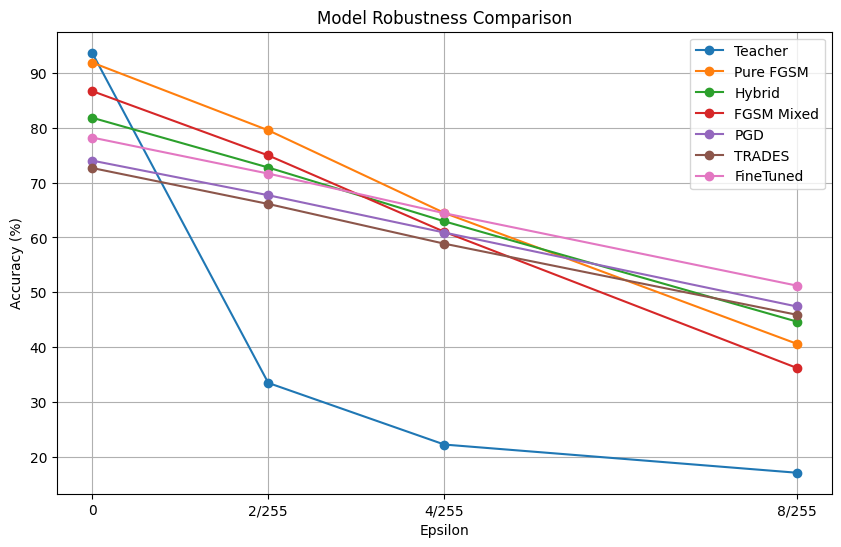

In [21]:
model_paths = [
    ("Teacher", "checkpoints/model_1_teacher.pth"),
    ("Pure FGSM", "checkpoints/model_2_pure_fgsm.pth"),
    ("Hybrid", "checkpoints/model_3_hybrid.pth"),
    ("FGSM Mixed", "checkpoints/model_4_mixed_v2.pth"),
    ("PGD", "checkpoints/model_5_pgd.pth"),
    ("TRADES", "checkpoints/model_6_trades.pth"),
    ("FineTuned", "checkpoints/model_7_finetuned.pth")
]

results = {}
epsilons = [0, 2/255, 4/255, 8/255]

print("\n📊 KARŞILAŞTIRMA RAPORU BAŞLIYOR...")

for name, path in model_paths:
    if not os.path.exists(path): continue
    
    model = ResNetCIFAR10().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    
    accs = []
    for eps in epsilons:
        if eps == 0:
            acc = evaluate_clean(model, test_loader)
        else:
            # Hızlı kontrol için FGSM kullanıyoruz, PGD ile de bakılabilir
            acc = evaluate_robust(model, test_loader, fgsm_attack, epsilon=eps)
        accs.append(acc * 100)
    
    results[name] = accs
    print(f"{name}: {accs}")

# Grafik Çizimi
plt.figure(figsize=(10, 6))
for name, accs in results.items():
    plt.plot(epsilons, accs, marker='o', label=name)

plt.title("Model Robustness Comparison")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy (%)")
plt.xticks(epsilons, ["0", "2/255", "4/255", "8/255"])
plt.legend()
plt.grid(True)
plt.savefig("final_comparison.png")
plt.show()

🚀 Modeller yükleniyor...

🎯 HEDEF SEÇİLDİ: İndeks 2826 | Gerçek Sınıf: Geyik


⚔️ SENARYO: TEMİZ (Saldırı Yok)


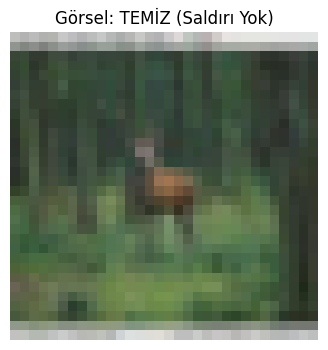

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ✅          | Geyik                | 100.00%
Pure FGSM       | ✅          | Geyik                | 99.89%
Hybrid          | ✅          | Geyik                | 84.88%
FGSM Mixed      | ✅          | Geyik                | 94.08%
PGD             | ✅          | Geyik                | 51.63%
TRADES          | ✅          | Geyik                | 46.98%
FineTuned       | ✅          | Geyik                | 47.74%
-----------------------------------------------------------------


⚔️ SENARYO: FGSM (Hafif - 2/255)


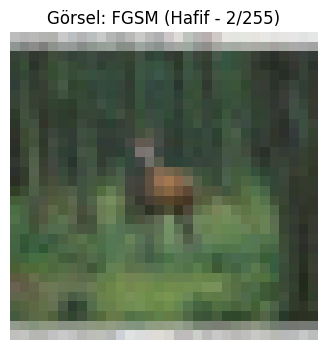

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ✅          | Geyik                | 99.91%
Pure FGSM       | ✅          | Geyik                | 99.89%
Hybrid          | ✅          | Geyik                | 84.81%
FGSM Mixed      | ✅          | Geyik                | 94.10%
PGD             | ✅          | Geyik                | 51.50%
TRADES          | ✅          | Geyik                | 46.92%
FineTuned       | ✅          | Geyik                | 47.56%
-----------------------------------------------------------------


⚔️ SENARYO: FGSM (Orta - 4/255)


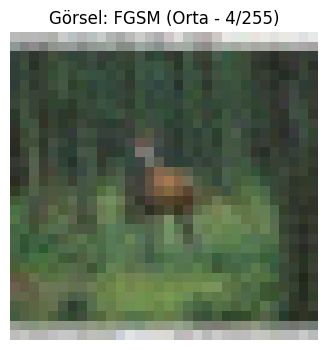

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ✅          | Geyik                | 99.91%
Pure FGSM       | ✅          | Geyik                | 99.89%
Hybrid          | ✅          | Geyik                | 84.81%
FGSM Mixed      | ✅          | Geyik                | 94.40%
PGD             | ✅          | Geyik                | 51.28%
TRADES          | ✅          | Geyik                | 46.76%
FineTuned       | ✅          | Geyik                | 47.29%
-----------------------------------------------------------------


⚔️ SENARYO: FGSM (Ağır - 8/255)


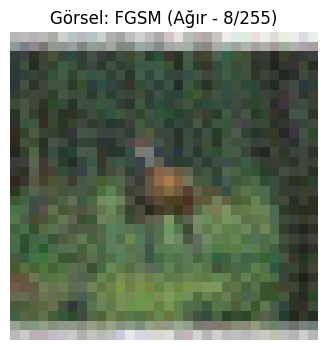

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ✅          | Geyik                | 97.88%
Pure FGSM       | ✅          | Geyik                | 99.88%
Hybrid          | ✅          | Geyik                | 84.63%
FGSM Mixed      | ✅          | Geyik                | 95.23%
PGD             | ✅          | Geyik                | 50.61%
TRADES          | ✅          | Geyik                | 46.23%
FineTuned       | ✅          | Geyik                | 46.60%
-----------------------------------------------------------------


⚔️ SENARYO: PGD (Yok Edici - 8/255)


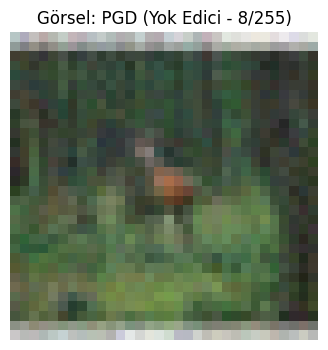

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Kus                  | 100.00%
Pure FGSM       | ✅          | Geyik                | 99.82%
Hybrid          | ✅          | Geyik                | 84.31%
FGSM Mixed      | ✅          | Geyik                | 94.10%
PGD             | ✅          | Geyik                | 51.28%
TRADES          | ✅          | Geyik                | 46.62%
FineTuned       | ✅          | Geyik                | 47.46%
-----------------------------------------------------------------


In [6]:
def visualize_ultimate_arena(index=None):
    import matplotlib.pyplot as plt
    
    # --- AYARLAR ---
    classes = ['Ucak', 'Otomobil', 'Kus', 'Kedi', 'Geyik', 
               'Kopek', 'Kurbaga', 'At', 'Gemi', 'Kamyon']
    
    # Saldırı Senaryoları (Adı, Saldırı Fonksiyonu, Epsilon, Steps)
    scenarios = [
        ("TEMİZ (Saldırı Yok)", None, 0, 0),
        ("FGSM (Hafif - 2/255)", fgsm_attack, 2/255, 1),
        ("FGSM (Orta - 4/255)", fgsm_attack, 4/255, 1),
        ("FGSM (Ağır - 8/255)", fgsm_attack, 8/255, 1),
        ("PGD (Yok Edici - 8/255)", pgd_attack, 8/255, 10)
    ]
    
    model_paths = [
        ("Teacher", "checkpoints/model_1_teacher.pth"),
        ("Pure FGSM", "checkpoints/model_2_pure_fgsm.pth"),
        ("Hybrid", "checkpoints/model_3_hybrid.pth"),
        ("FGSM Mixed", "checkpoints/model_4_mixed_v2.pth"),
        ("PGD", "checkpoints/model_5_pgd.pth"),
        ("TRADES", "checkpoints/model_6_trades.pth"),
        ("FineTuned", "checkpoints/model_7_finetuned.pth")
    ]
    
    # --- 1. MODELLERİ YÜKLE ---
    print("🚀 Modeller yükleniyor...")
    loaded_models = {}
    for name, path in model_paths:
        if os.path.exists(path):
            m = ResNetCIFAR10().to(device)
            m.load_state_dict(torch.load(path, map_location=device))
            m.eval()
            loaded_models[name] = m
        else:
            print(f"⚠️ Uyarı: {name} bulunamadı ({path})")

    # Teacher modelini saldırı üretmek için ayrıca alalım
    attacker_model = loaded_models["Teacher"] 

    # --- 2. RESİM SEÇİMİ ---
    if index is None:
        import random
        index = random.randint(0, len(test_loader.dataset))
    
    x_raw, y_true = test_loader.dataset[index]
    x_raw, y_true = x_raw.unsqueeze(0).to(device), torch.tensor([y_true]).to(device)
    true_class = classes[y_true.item()]
    
    print(f"\n🎯 HEDEF SEÇİLDİ: İndeks {index} | Gerçek Sınıf: {true_class}")
    print("="*80)

    # Helper: Görseli çizmek için
    def show_image(tensor, title):
        img = denormalize(tensor).squeeze().permute(1, 2, 0).cpu().detach().numpy()
        img = np.clip(img, 0, 1)
        plt.figure(figsize=(4, 4))
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
        plt.show()

    # --- 3. DÖNGÜ (HER SALDIRI İÇİN) ---
    for scenario_name, attack_fn, eps, steps in scenarios:
        print(f"\n\n⚔️ SENARYO: {scenario_name}")
        
        # A) Saldırıyı Üret
        if attack_fn is None:
            x_adv = x_raw
        else:
            # PGD ise steps parametresini kullan, değilse sadece epsilon
            if attack_fn == pgd_attack:
                x_adv = attack_fn(attacker_model, x_raw, y_true, epsilon=eps, device=device, steps=steps)
            else:
                x_adv = attack_fn(attacker_model, x_raw, y_true, epsilon=eps, device=device)
        
        # B) Resmi Göster
        show_image(x_adv, f"Görsel: {scenario_name}")
        
        # C) Modelleri Test Et
        print(f"{'MODEL':<15} | {'DURUM':<10} | {'TAHMİN':<20} | {'GÜVEN (%)':<10}")
        print("-" * 65)
        
        for name, model in loaded_models.items():
            with torch.no_grad():
                output = model(x_adv)
                prob, pred = F.softmax(output, dim=1).max(1)
                
            pred_class = classes[pred.item()]
            confidence = prob.item() * 100
            
            if pred.item() == y_true.item():
                status = "✅"
                color_code = "\033[92m" # Yeşil
            else:
                status = "❌"
                color_code = "\033[91m" # Kırmızı
            
            # Renkli çıktı (Jupyter destekler)
            print(f"{color_code}{name:<15} | {status:<10} | {pred_class:<20} | {confidence:.2f}%\033[0m")
        
        print("-" * 65)

# --- ÇALIŞTIR ---
# Rastgele bir örnek için:
visualize_ultimate_arena()

# Veya belirli bir zor örnek biliyorsan (örn: 100. resim):
# visualize_ultimate_arena(100)

In [7]:
from PIL import Image

def test_custom_image(image_path, true_label_index=6):
    """
    image_path: Yüklediğin resmin dosya yolu (örn: 'kurbaga.jpg')
    true_label_index: Resmin gerçek sınıfının numarası (CIFAR-10'da Kurbağa = 6)
    """
    
    # CIFAR-10 Sınıf Listesi
    classes = ['Ucak', 'Otomobil', 'Kus', 'Kedi', 'Geyik', 
               'Kopek', 'Kurbaga', 'At', 'Gemi', 'Kamyon']
    
    true_label_name = classes[true_label_index]
    print(f"\n🌍 DIŞ DÜNYADAN GELEN GÖRSEL TEST EDİLİYOR: {true_label_name.upper()}")
    print("="*80)

    # 1. GÖRSEL ÖN İŞLEME (PREPROCESSING)
    # Dışarıdan gelen resmi modelin anlayacağı 32x32 formatına sokuyoruz
    transform_custom = transforms.Compose([
        transforms.Resize((32, 32)),       # 32x32 piksele küçült
        transforms.ToTensor(),             # Tensöre çevir
        transforms.Normalize(cifar10_mean, cifar10_std) # Normalize et
    ])
    
    try:
        img_pil = Image.open(image_path).convert('RGB') # Resmi aç (PNG ise RGB'ye zorla)
        x_raw = transform_custom(img_pil).unsqueeze(0).to(device) # Batch boyutu ekle (1, 3, 32, 32)
        y_true = torch.tensor([true_label_index]).to(device)      # Etiketi tensör yap
    except Exception as e:
        print(f"❌ Hata: Resim yüklenemedi. Dosya yolunu kontrol et. Hata: {e}")
        return

    # 2. MODELLERİ YÜKLE
    model_paths = [
        ("Teacher", "checkpoints/model_1_teacher.pth"),
        ("Pure FGSM", "checkpoints/model_2_pure_fgsm.pth"),
        ("Hybrid", "checkpoints/model_3_hybrid.pth"),
        ("FGSM Mixed", "checkpoints/model_4_mixed_v2.pth"),
        ("PGD", "checkpoints/model_5_pgd.pth"),
        ("TRADES", "checkpoints/model_6_trades.pth"),
        ("FineTuned", "checkpoints/model_7_finetuned.pth")
    ]
    
    loaded_models = {}
    for name, path in model_paths:
        if os.path.exists(path):
            m = ResNetCIFAR10().to(device)
            m.load_state_dict(torch.load(path, map_location=device))
            m.eval()
            loaded_models[name] = m

    attacker_model = loaded_models["Teacher"] # Saldırıyı Teacher'a göre dizayn edelim

    # 3. SENARYOLAR VE GÖRSELLEŞTİRME
    scenarios = [
        ("TEMİZ (Orijinal)", None, 0, 0),
        ("FGSM (Hafif - 2/255)", fgsm_attack, 2/255, 1),
        ("FGSM (Orta - 4/255)", fgsm_attack, 4/255, 1),
        ("FGSM (Ağır - 8/255)", fgsm_attack, 8/255, 1),
        ("PGD (Yok Edici - 8/255)", pgd_attack, 8/255, 10)
    ]

    # Helper: Resim Çizdirme
    def show_image(tensor, title):
        img = denormalize(tensor).squeeze().permute(1, 2, 0).cpu().detach().numpy()
        img = np.clip(img, 0, 1)
        plt.figure(figsize=(3, 3))
        plt.imshow(img)
        plt.title(title)
        plt.axis('off')
        plt.show()

    # DÖNGÜ
    for scenario_name, attack_fn, eps, steps in scenarios:
        print(f"\n⚔️ SENARYO: {scenario_name}")
        
        # A) Saldırı Üret
        if attack_fn is None:
            x_adv = x_raw
        else:
            if attack_fn == pgd_attack:
                x_adv = attack_fn(attacker_model, x_raw, y_true, epsilon=eps, device=device, steps=steps)
            else:
                x_adv = attack_fn(attacker_model, x_raw, y_true, epsilon=eps, device=device)
        
        # B) Resmi Göster
        show_image(x_adv, scenario_name)
        
        # C) Tabloyu Yazdır
        print(f"{'MODEL':<15} | {'DURUM':<10} | {'TAHMİN':<20} | {'GÜVEN (%)':<10}")
        print("-" * 65)
        
        for name, model in loaded_models.items():
            with torch.no_grad():
                output = model(x_adv)
                prob, pred = F.softmax(output, dim=1).max(1)
            
            pred_class = classes[pred.item()]
            confidence = prob.item() * 100
            
            if pred.item() == true_label_index:
                status = "✅"
                color_code = "\033[92m" # Yeşil
            else:
                status = "❌"
                color_code = "\033[91m" # Kırmızı
            
            print(f"{color_code}{name:<15} | {status:<10} | {pred_class:<20} | {confidence:.2f}%\033[0m")
        print("-" * 65)

# --- NASIL KULLANILIR? ---
# 1. Dosya yükle kısmından 'test.jpg' adıyla bir kurbağa resmi yükle.
# 2. Aşağıdaki komutu çalıştır:
# test_custom_image("test.jpg", true_label_index=6) 
# (Not: Kurbağa=6, Kedi=3, Uçak=0, Otomobil=1 vb.)


🌍 DIŞ DÜNYADAN GELEN GÖRSEL TEST EDİLİYOR: KURBAGA

⚔️ SENARYO: TEMİZ (Orijinal)


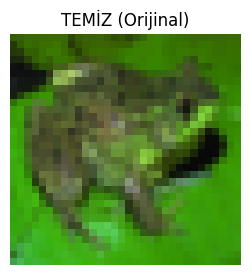

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ✅          | Kurbaga              | 100.00%
Pure FGSM       | ✅          | Kurbaga              | 99.99%
Hybrid          | ✅          | Kurbaga              | 86.07%
FGSM Mixed      | ✅          | Kurbaga              | 98.64%
PGD             | ✅          | Kurbaga              | 51.79%
TRADES          | ✅          | Kurbaga              | 42.87%
FineTuned       | ✅          | Kurbaga              | 51.42%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Hafif - 2/255)


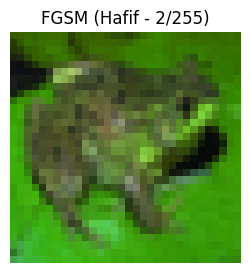

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ✅          | Kurbaga              | 97.09%
Pure FGSM       | ✅          | Kurbaga              | 99.99%
Hybrid          | ✅          | Kurbaga              | 85.76%
FGSM Mixed      | ✅          | Kurbaga              | 98.41%
PGD             | ✅          | Kurbaga              | 51.70%
TRADES          | ✅          | Kurbaga              | 42.86%
FineTuned       | ✅          | Kurbaga              | 51.12%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Orta - 4/255)


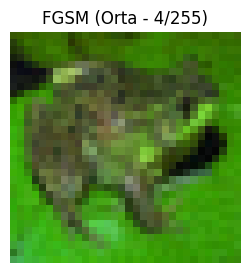

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ✅          | Kurbaga              | 50.65%
Pure FGSM       | ✅          | Kurbaga              | 99.98%
Hybrid          | ✅          | Kurbaga              | 85.50%
FGSM Mixed      | ✅          | Kurbaga              | 98.21%
PGD             | ✅          | Kurbaga              | 51.67%
TRADES          | ✅          | Kurbaga              | 42.95%
FineTuned       | ✅          | Kurbaga              | 50.78%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Ağır - 8/255)


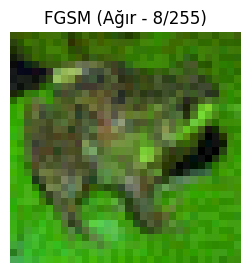

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Kedi                 | 73.54%
Pure FGSM       | ✅          | Kurbaga              | 99.98%
Hybrid          | ✅          | Kurbaga              | 84.95%
FGSM Mixed      | ✅          | Kurbaga              | 97.85%
PGD             | ✅          | Kurbaga              | 51.72%
TRADES          | ✅          | Kurbaga              | 43.31%
FineTuned       | ✅          | Kurbaga              | 50.26%
-----------------------------------------------------------------

⚔️ SENARYO: PGD (Yok Edici - 8/255)


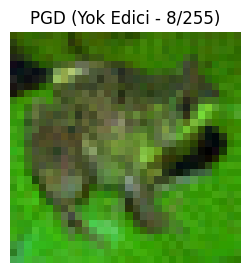

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Kedi                 | 100.00%
Pure FGSM       | ✅          | Kurbaga              | 99.99%
Hybrid          | ✅          | Kurbaga              | 84.26%
FGSM Mixed      | ✅          | Kurbaga              | 98.04%
PGD             | ✅          | Kurbaga              | 51.85%
TRADES          | ✅          | Kurbaga              | 42.64%
FineTuned       | ✅          | Kurbaga              | 51.12%
-----------------------------------------------------------------


In [37]:
test_custom_image("test.jpg", true_label_index=6) 


🌍 DIŞ DÜNYADAN GELEN GÖRSEL TEST EDİLİYOR: KURBAGA

⚔️ SENARYO: TEMİZ (Orijinal)


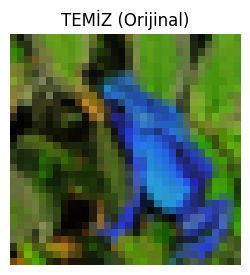

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ✅          | Kurbaga              | 97.76%
Pure FGSM       | ❌          | Kus                  | 73.89%
Hybrid          | ❌          | Kus                  | 86.24%
FGSM Mixed      | ✅          | Kurbaga              | 56.17%
PGD             | ❌          | Kus                  | 91.02%
TRADES          | ❌          | Kus                  | 62.74%
FineTuned       | ❌          | Kus                  | 72.83%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Hafif - 2/255)


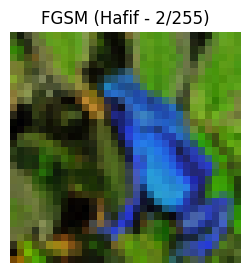

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Kus                  | 99.92%
Pure FGSM       | ❌          | Kus                  | 80.78%
Hybrid          | ❌          | Kus                  | 86.50%
FGSM Mixed      | ✅          | Kurbaga              | 54.14%
PGD             | ❌          | Kus                  | 91.19%
TRADES          | ❌          | Kus                  | 62.85%
FineTuned       | ❌          | Kus                  | 72.88%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Orta - 4/255)


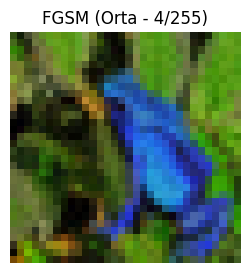

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Kus                  | 100.00%
Pure FGSM       | ❌          | Kus                  | 85.75%
Hybrid          | ❌          | Kus                  | 86.69%
FGSM Mixed      | ✅          | Kurbaga              | 52.47%
PGD             | ❌          | Kus                  | 91.37%
TRADES          | ❌          | Kus                  | 62.96%
FineTuned       | ❌          | Kus                  | 72.92%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Ağır - 8/255)


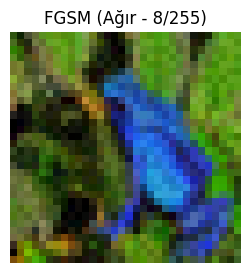

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Kus                  | 100.00%
Pure FGSM       | ❌          | Kus                  | 91.80%
Hybrid          | ❌          | Kus                  | 87.02%
FGSM Mixed      | ✅          | Kurbaga              | 50.55%
PGD             | ❌          | Kus                  | 91.70%
TRADES          | ❌          | Kus                  | 63.13%
FineTuned       | ❌          | Kus                  | 72.88%
-----------------------------------------------------------------

⚔️ SENARYO: PGD (Yok Edici - 8/255)


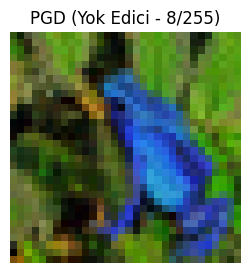

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Kus                  | 100.00%
Pure FGSM       | ❌          | Kus                  | 86.28%
Hybrid          | ❌          | Kus                  | 87.24%
FGSM Mixed      | ✅          | Kurbaga              | 54.77%
PGD             | ❌          | Kus                  | 91.30%
TRADES          | ❌          | Kus                  | 62.89%
FineTuned       | ❌          | Kus                  | 73.32%
-----------------------------------------------------------------


In [43]:
test_custom_image("test3.jpg", true_label_index=6) 


🌍 DIŞ DÜNYADAN GELEN GÖRSEL TEST EDİLİYOR: KURBAGA

⚔️ SENARYO: TEMİZ (Orijinal)


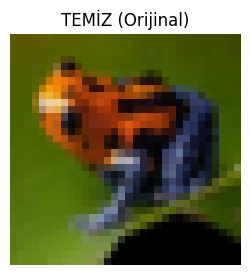

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ✅          | Kurbaga              | 99.78%
Pure FGSM       | ✅          | Kurbaga              | 99.08%
Hybrid          | ✅          | Kurbaga              | 62.59%
FGSM Mixed      | ✅          | Kurbaga              | 90.54%
PGD             | ✅          | Kurbaga              | 37.20%
TRADES          | ✅          | Kurbaga              | 31.28%
FineTuned       | ✅          | Kurbaga              | 37.15%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Hafif - 2/255)


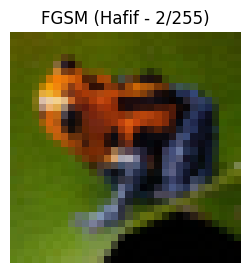

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Otomobil             | 75.11%
Pure FGSM       | ✅          | Kurbaga              | 99.00%
Hybrid          | ✅          | Kurbaga              | 61.92%
FGSM Mixed      | ✅          | Kurbaga              | 90.18%
PGD             | ✅          | Kurbaga              | 37.22%
TRADES          | ✅          | Kurbaga              | 31.14%
FineTuned       | ✅          | Kurbaga              | 37.04%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Orta - 4/255)


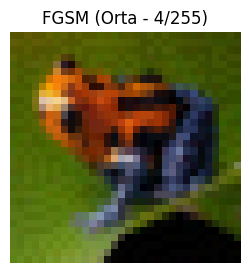

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Otomobil             | 57.96%
Pure FGSM       | ✅          | Kurbaga              | 98.88%
Hybrid          | ✅          | Kurbaga              | 61.39%
FGSM Mixed      | ✅          | Kurbaga              | 90.04%
PGD             | ✅          | Kurbaga              | 37.37%
TRADES          | ✅          | Kurbaga              | 31.08%
FineTuned       | ✅          | Kurbaga              | 37.04%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Ağır - 8/255)


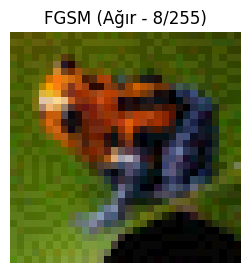

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Otomobil             | 46.49%
Pure FGSM       | ✅          | Kurbaga              | 98.91%
Hybrid          | ✅          | Kurbaga              | 61.15%
FGSM Mixed      | ✅          | Kurbaga              | 90.25%
PGD             | ✅          | Kurbaga              | 37.92%
TRADES          | ✅          | Kurbaga              | 31.26%
FineTuned       | ✅          | Kurbaga              | 37.33%
-----------------------------------------------------------------

⚔️ SENARYO: PGD (Yok Edici - 8/255)


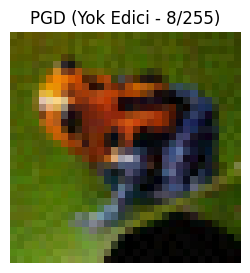

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Otomobil             | 99.98%
Pure FGSM       | ✅          | Kurbaga              | 98.99%
Hybrid          | ✅          | Kurbaga              | 60.16%
FGSM Mixed      | ✅          | Kurbaga              | 90.33%
PGD             | ✅          | Kurbaga              | 36.54%
TRADES          | ✅          | Kurbaga              | 30.72%
FineTuned       | ✅          | Kurbaga              | 35.96%
-----------------------------------------------------------------


In [44]:
test_custom_image("test1.jpg", true_label_index=6) 


🌍 DIŞ DÜNYADAN GELEN GÖRSEL TEST EDİLİYOR: UCAK

⚔️ SENARYO: TEMİZ (Orijinal)


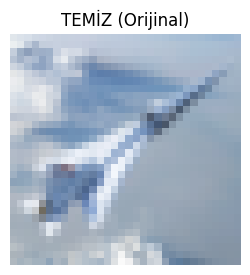

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ✅          | Ucak                 | 99.99%
Pure FGSM       | ✅          | Ucak                 | 99.92%
Hybrid          | ✅          | Ucak                 | 93.23%
FGSM Mixed      | ✅          | Ucak                 | 99.39%
PGD             | ✅          | Ucak                 | 84.19%
TRADES          | ✅          | Ucak                 | 70.99%
FineTuned       | ✅          | Ucak                 | 76.35%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Hafif - 2/255)


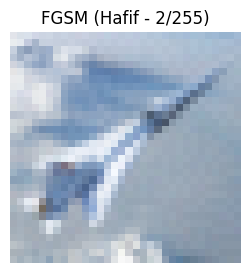

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Kamyon               | 54.51%
Pure FGSM       | ✅          | Ucak                 | 99.93%
Hybrid          | ✅          | Ucak                 | 92.96%
FGSM Mixed      | ✅          | Ucak                 | 99.43%
PGD             | ✅          | Ucak                 | 83.89%
TRADES          | ✅          | Ucak                 | 70.82%
FineTuned       | ✅          | Ucak                 | 76.00%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Orta - 4/255)


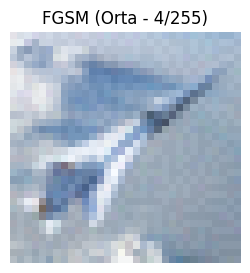

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Gemi                 | 69.29%
Pure FGSM       | ✅          | Ucak                 | 99.93%
Hybrid          | ✅          | Ucak                 | 92.49%
FGSM Mixed      | ✅          | Ucak                 | 99.46%
PGD             | ✅          | Ucak                 | 83.41%
TRADES          | ✅          | Ucak                 | 70.45%
FineTuned       | ✅          | Ucak                 | 75.40%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Ağır - 8/255)


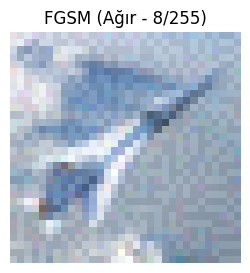

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Gemi                 | 73.76%
Pure FGSM       | ✅          | Ucak                 | 99.92%
Hybrid          | ✅          | Ucak                 | 90.83%
FGSM Mixed      | ✅          | Ucak                 | 99.48%
PGD             | ✅          | Ucak                 | 81.91%
TRADES          | ✅          | Ucak                 | 68.78%
FineTuned       | ✅          | Ucak                 | 73.43%
-----------------------------------------------------------------

⚔️ SENARYO: PGD (Yok Edici - 8/255)


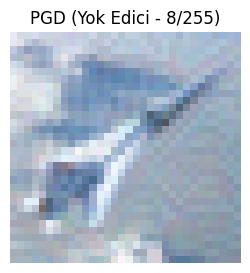

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Gemi                 | 100.00%
Pure FGSM       | ✅          | Ucak                 | 99.93%
Hybrid          | ✅          | Ucak                 | 91.10%
FGSM Mixed      | ✅          | Ucak                 | 99.31%
PGD             | ✅          | Ucak                 | 81.81%
TRADES          | ✅          | Ucak                 | 68.85%
FineTuned       | ✅          | Ucak                 | 73.05%
-----------------------------------------------------------------


In [51]:
test_custom_image("test8.png", true_label_index=0) 


🌍 DIŞ DÜNYADAN GELEN GÖRSEL TEST EDİLİYOR: UCAK

⚔️ SENARYO: TEMİZ (Orijinal)


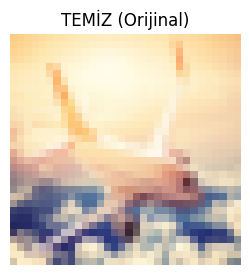

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ✅          | Ucak                 | 99.99%
Pure FGSM       | ✅          | Ucak                 | 86.57%
Hybrid          | ✅          | Ucak                 | 43.33%
FGSM Mixed      | ✅          | Ucak                 | 88.02%
PGD             | ❌          | Gemi                 | 36.97%
TRADES          | ❌          | Gemi                 | 36.14%
FineTuned       | ❌          | Gemi                 | 37.86%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Hafif - 2/255)


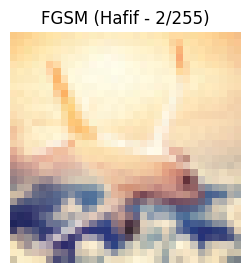

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Kedi                 | 53.98%
Pure FGSM       | ✅          | Ucak                 | 84.72%
Hybrid          | ✅          | Ucak                 | 43.17%
FGSM Mixed      | ✅          | Ucak                 | 87.66%
PGD             | ❌          | Gemi                 | 36.92%
TRADES          | ❌          | Gemi                 | 36.13%
FineTuned       | ❌          | Gemi                 | 37.63%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Orta - 4/255)


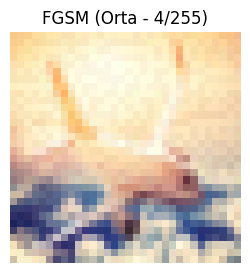

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Kedi                 | 80.70%
Pure FGSM       | ✅          | Ucak                 | 83.89%
Hybrid          | ✅          | Ucak                 | 43.32%
FGSM Mixed      | ✅          | Ucak                 | 87.40%
PGD             | ❌          | Gemi                 | 36.58%
TRADES          | ❌          | Gemi                 | 35.94%
FineTuned       | ❌          | Gemi                 | 37.13%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Ağır - 8/255)


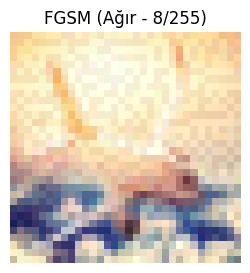

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Kedi                 | 82.48%
Pure FGSM       | ✅          | Ucak                 | 82.83%
Hybrid          | ✅          | Ucak                 | 44.17%
FGSM Mixed      | ✅          | Ucak                 | 86.83%
PGD             | ❌          | Gemi                 | 35.29%
TRADES          | ❌          | Gemi                 | 35.24%
FineTuned       | ❌          | Gemi                 | 35.21%
-----------------------------------------------------------------

⚔️ SENARYO: PGD (Yok Edici - 8/255)


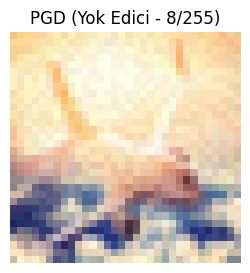

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Kedi                 | 100.00%
Pure FGSM       | ✅          | Ucak                 | 85.71%
Hybrid          | ✅          | Ucak                 | 38.68%
FGSM Mixed      | ✅          | Ucak                 | 83.84%
PGD             | ❌          | Gemi                 | 35.19%
TRADES          | ❌          | Gemi                 | 35.11%
FineTuned       | ❌          | Gemi                 | 36.78%
-----------------------------------------------------------------


In [48]:
test_custom_image("test7.png", true_label_index=0) 


🌍 DIŞ DÜNYADAN GELEN GÖRSEL TEST EDİLİYOR: UCAK

⚔️ SENARYO: TEMİZ (Orijinal)


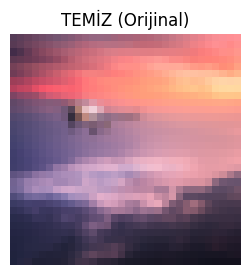

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ✅          | Ucak                 | 100.00%
Pure FGSM       | ✅          | Ucak                 | 77.79%
Hybrid          | ✅          | Ucak                 | 47.07%
FGSM Mixed      | ❌          | Gemi                 | 52.35%
PGD             | ❌          | Gemi                 | 41.28%
TRADES          | ❌          | Gemi                 | 30.43%
FineTuned       | ❌          | Gemi                 | 40.06%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Hafif - 2/255)


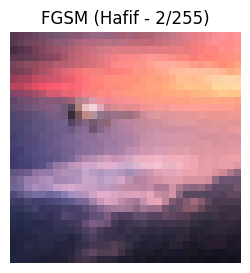

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ✅          | Ucak                 | 72.11%
Pure FGSM       | ✅          | Ucak                 | 75.11%
Hybrid          | ✅          | Ucak                 | 45.96%
FGSM Mixed      | ❌          | Gemi                 | 55.22%
PGD             | ❌          | Gemi                 | 41.63%
TRADES          | ❌          | Gemi                 | 30.60%
FineTuned       | ❌          | Gemi                 | 40.52%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Orta - 4/255)


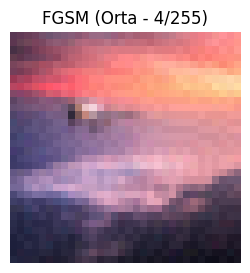

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Kedi                 | 54.28%
Pure FGSM       | ✅          | Ucak                 | 70.20%
Hybrid          | ✅          | Ucak                 | 43.84%
FGSM Mixed      | ❌          | Gemi                 | 58.69%
PGD             | ❌          | Gemi                 | 42.04%
TRADES          | ❌          | Gemi                 | 30.77%
FineTuned       | ❌          | Gemi                 | 41.07%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Ağır - 8/255)


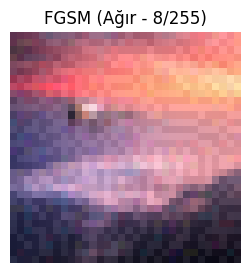

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Kurbaga              | 48.15%
Pure FGSM       | ✅          | Ucak                 | 51.25%
Hybrid          | ❌          | Gemi                 | 43.51%
FGSM Mixed      | ❌          | Gemi                 | 66.49%
PGD             | ❌          | Gemi                 | 43.08%
TRADES          | ❌          | Gemi                 | 31.19%
FineTuned       | ❌          | Gemi                 | 42.55%
-----------------------------------------------------------------

⚔️ SENARYO: PGD (Yok Edici - 8/255)


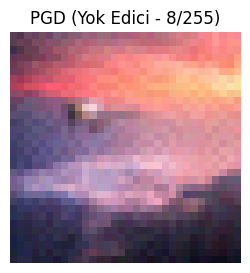

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Kedi                 | 100.00%
Pure FGSM       | ✅          | Ucak                 | 49.75%
Hybrid          | ❌          | Gemi                 | 41.56%
FGSM Mixed      | ❌          | Gemi                 | 59.41%
PGD             | ❌          | Gemi                 | 42.00%
TRADES          | ❌          | Gemi                 | 30.43%
FineTuned       | ❌          | Gemi                 | 41.42%
-----------------------------------------------------------------


In [53]:
test_custom_image("test9.png", true_label_index=0) 


🌍 DIŞ DÜNYADAN GELEN GÖRSEL TEST EDİLİYOR: UCAK

⚔️ SENARYO: TEMİZ (Orijinal)


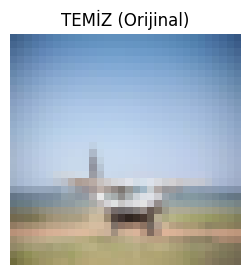

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ✅          | Ucak                 | 98.60%
Pure FGSM       | ✅          | Ucak                 | 99.14%
Hybrid          | ✅          | Ucak                 | 57.75%
FGSM Mixed      | ✅          | Ucak                 | 81.13%
PGD             | ❌          | Gemi                 | 53.82%
TRADES          | ❌          | Gemi                 | 60.73%
FineTuned       | ✅          | Ucak                 | 45.66%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Hafif - 2/255)


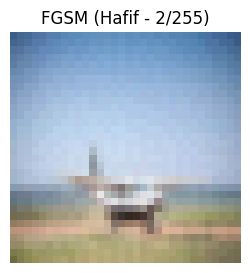

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Geyik                | 99.12%
Pure FGSM       | ✅          | Ucak                 | 98.97%
Hybrid          | ✅          | Ucak                 | 57.17%
FGSM Mixed      | ✅          | Ucak                 | 80.82%
PGD             | ❌          | Gemi                 | 53.84%
TRADES          | ❌          | Gemi                 | 60.67%
FineTuned       | ✅          | Ucak                 | 45.59%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Orta - 4/255)


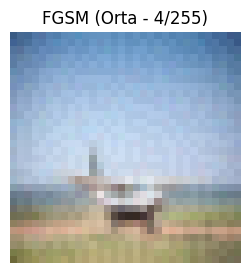

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Geyik                | 92.22%
Pure FGSM       | ✅          | Ucak                 | 98.77%
Hybrid          | ✅          | Ucak                 | 55.98%
FGSM Mixed      | ✅          | Ucak                 | 80.09%
PGD             | ❌          | Gemi                 | 53.68%
TRADES          | ❌          | Gemi                 | 60.54%
FineTuned       | ✅          | Ucak                 | 45.55%
-----------------------------------------------------------------

⚔️ SENARYO: FGSM (Ağır - 8/255)


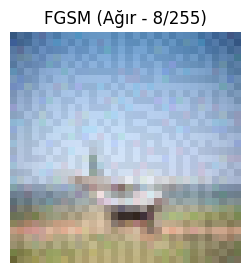

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Geyik                | 65.68%
Pure FGSM       | ✅          | Ucak                 | 94.83%
Hybrid          | ✅          | Ucak                 | 52.70%
FGSM Mixed      | ✅          | Ucak                 | 75.41%
PGD             | ❌          | Gemi                 | 53.19%
TRADES          | ❌          | Gemi                 | 60.26%
FineTuned       | ✅          | Ucak                 | 45.04%
-----------------------------------------------------------------

⚔️ SENARYO: PGD (Yok Edici - 8/255)


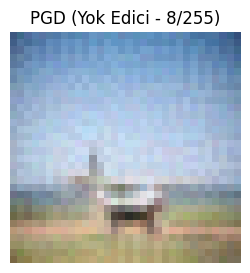

MODEL           | DURUM      | TAHMİN               | GÜVEN (%) 
-----------------------------------------------------------------
Teacher         | ❌          | Geyik                | 100.00%
Pure FGSM       | ✅          | Ucak                 | 93.63%
Hybrid          | ✅          | Ucak                 | 57.32%
FGSM Mixed      | ✅          | Ucak                 | 72.55%
PGD             | ❌          | Gemi                 | 53.10%
TRADES          | ❌          | Gemi                 | 60.03%
FineTuned       | ✅          | Ucak                 | 45.93%
-----------------------------------------------------------------


In [54]:
test_custom_image("test10.png", true_label_index=0) 